## Set up local environment
Import libraries

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression, Lasso
from wordcloud import WordCloud, STOPWORDS

Plot silly graph for tabular example

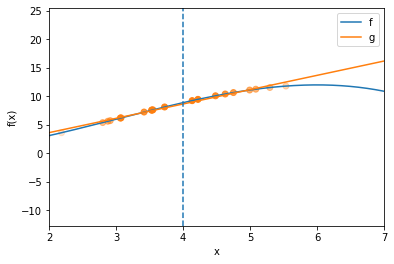

In [2]:
# Black-box model
def f(x):
    return x**2 - (x**3) / 9
f = np.vectorize(f)

# Point of interest
x0 = 4
sx = 2

# Sampler from normal distribution
sampler = stats.norm(loc=x0, scale=sx)

# Perturbed data set
x = sampler.rvs(30, random_state=42)
d = pd.DataFrame({'x':x, 'f':f(x)})
w = np.exp(np.power(d['x'] - x0, 2) / -2) # Exponential weights
d['w'] = w

# Fit local model
m = LinearRegression()
m.fit(
    X=d[['x']],
    y=d['f'],
    sample_weight=d['w']
)

# Surrogate model
def g(x):
    return m.intercept_ + m.coef_.item(0) * x
g = np.vectorize(g)

# Define range
x = np.arange(0, 10, 0.01)

# Plot f, d and g
plt.plot(x, f(x), label='f')
plt.scatter(d['x'], d['f'], color='C1', alpha=d['w'])
plt.plot(x, g(x), color='C1', label='g')

# Aesthetics
plt.axvline(x0, ls='--', color='C0')
plt.xlim(2, 7)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

# Show & save
# plt.savefig('../../fig/tabular.png', bbox_inches='tight', dpi=200)
plt.show()

Read comments as data frame

In [3]:
# Load data
df = pd.read_csv('../../dat/scored_comments.csv', encoding='utf-8')

# Remove line skip strings
df['comment'] = df['comment'].str.replace('\n', '')

# Drop NAs
df = df.dropna(how='any').reset_index(drop=True)

# Count
print(f'Number of comments:{len(df)}')
print(f"Within {df['date'].min()} and {df['date'].max()}")

# Visualize
df.head()

Number of comments:4332
Within 2021-07-21T19:49:24Z and 2022-05-12T13:06:58Z


,comment,author,date,score
0,1:11 amazing how missing features that previou...,Ivan Galvagno,2022-05-12T13:06:58Z,0.129
1,How tf they managed to screw this up?,Rbarzevedo,2022-05-12T12:35:43Z,0.167
2,Still a weird choice to put a remix of kicksta...,Some Turkey Nuts,2022-05-11T21:27:56Z,0.090
3,Im still waiting for the full game to come out.,Dozer,2022-05-11T13:57:38Z,0.000
4,My dads generation had Bad Company. My generat...,Leadkiss,2022-05-11T12:21:19Z,0.280


Count how many comments have _some_ negative tone.

In [4]:
# Declare negative tone indicator
df['neg'] = (df['score'] > 0).astype(int)

# Summarize
neg = df['neg'].mean()
print(f"{round(neg * 100, 1)}% of comments have some degree of negativity ({df['neg'].sum()}).")

# Keep only negative comments
df = df[df['neg'] > 0].reset_index(drop=True)

46.4% of comments have some degree of negativity (2011).


Short list of negative comments

In [5]:
# Three random comments
t = df[['comment','score']].sample(6, random_state=42)

# To latex
# print(t.to_latex(index=False))

for comment in t['comment']:
    print(comment)

This remix is not it. like I get the appeal of having a recognizable song but like, if it's gonna be *this* bad just dont.
If only , we have been sold a lie, you should be sued for misleading your customers.  I hope you go bust. There should be a law against this sort of misleading content.
Trailer full 'o lies. BF2042 was the last EA game I will ever buy.
It looks like they meshed Battlefield 3 with Battlefield Bad Company 2, if that's the case I will waiting
Wait guys...If you think about it, the game was just as advertised. In the trailer, there are only like 4-5 specialists visible at a time. This is due to the game being so bad that almost all the servers are full of bots, hence the lack of specialists, vehicle spam, and annoying quips.
Around the6th time I've watched this trailer the first 4 was out of pure hype and excitement the other 2 was out of pure heart ache and sadness I hate to see a franchise as good as this die like this


Initialize VADER

In [6]:
vader = SentimentIntensityAnalyzer()

## Example for a single comment
Extract a single comment from the entire comment section and manually repeat the process carried out by LIME.

In [7]:
# Extract one comment from `df`
c = df.iloc[1]
comment = c['comment']
print('Selected comment:', comment, sep='\n  ')

# Comment into list
words = [word for word in comment.split(' ')]
print('Comment as list of words:', words, sep='\n  ')

Selected comment:
  How tf they managed to screw this up?
Comment as list of words:
  ['How', 'tf', 'they', 'managed', 'to', 'screw', 'this', 'up?']


Randomly take out words from comment

In [8]:
# Initialize bernoulli distribution
B = stats.bernoulli(p=0.8)

# Select words based on Bernoulli random variable (N times)
d = []
for i in range(100):
    d.append(list(B.rvs(len(words), random_state=42+i)))
    
# Modifications to data frame
t = pd.DataFrame(data=d, columns=words)

# Remove duplicates
t = t.drop_duplicates()

# Set weight based on closeness to original text
t['weight'] = t.sum(axis=1) / len(words)

# Drop entries where closeness is 1
t = t[t['weight'] < 1].reset_index(drop=True)

# Get original score
t['score0'] = c['score']

Score new observations

In [9]:
# Initialize empty list
scores = []

for i in t.index.values:
    # Extract modified version of text
    mod = t.iloc[i, :-1]
    mod = ' '.join(list(mod[mod > 0].index.values))

    # Append score to list
    scores.append(vader.polarity_scores(mod)['neg'])

# Add new scores to `t`
t['score1'] = scores

# Visualize
t.head()

# To latex
# print(t.head().to_latex(float_format='%.3f', index=False))

,How,tf,they,managed,to,screw,this,up?,weight,score0,score1
0,1,0,1,1,1,1,1,0,0.750,0.167,0.189
1,1,1,1,1,1,0,1,1,0.875,0.167,0.000
2,0,1,1,1,1,1,1,1,0.875,0.167,0.167
3,1,0,1,1,1,1,1,1,0.875,0.167,0.167
4,1,0,1,1,1,1,0,1,0.750,0.167,0.189


Fit lasso

In [10]:
penalties = np.arange(0.01, 1 + 0.01, 0.01)
coefs = []
for penalty in penalties:
    # Fit lasso
    m = Lasso(alpha=penalty, fit_intercept=False)
    m.fit(X=t[['score1']], y=t.loc[:, 'How':'up?'], sample_weight=t['weight'])

    # Append coefs
    coefs.append(list(np.transpose(m.coef_)[0]))

# To df
s = pd.DataFrame(data=coefs, columns=t.columns[:-3])

Plot convergence

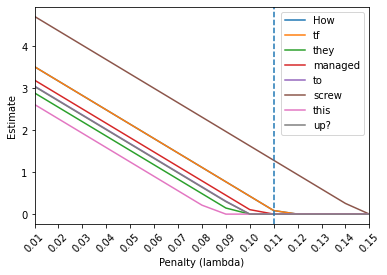

In [11]:
for col in s.columns:
    plt.plot(penalties, s[col].values, label=col)

# Cutoff
cutoff = 0.11
plt.axvline(x=cutoff, ls='--')

# Ticks and labels
plt.xticks(penalties, rotation=45)
plt.xlim(0.01, 0.15)
plt.xlabel('Penalty (lambda)')
plt.ylabel('Estimate')
plt.legend()

# Show and save
# plt.savefig('../../fig/lasso.png', bbox_inches='tight', dpi=200)
plt.show()


LIME explanation at data point

In [12]:
# Re-fit lassso with penalty=0.1
m = Lasso(alpha=cutoff, fit_intercept=False)
m.fit(X=t[['score1']], y=t.loc[:, 'How':'up?'], sample_weight=t['weight'])

# Get fitted parameters
res = pd.DataFrame({'Word':t.columns.values[:len(words)], 'Coef':m.coef_.flatten()})

# Visualize
res[res['Coef'] > 0].round(2)

# To latex
# print(res[res['Coef'] > 0].to_latex(index=False, float_format='%.2f'))

,Word,Coef
0,How,0.08
1,tf,0.08
5,screw,1.28


## General results
Split negative score into quartiles

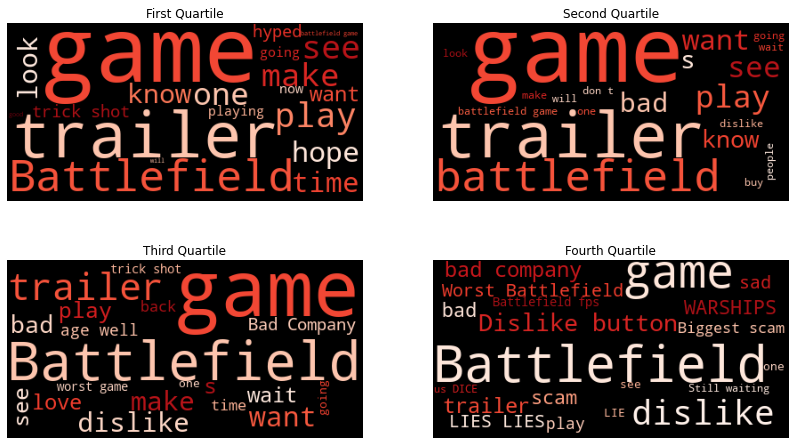

In [13]:
# Assign quartiles
df['score_quartile'] = pd.qcut(df['score'], q=4, labels=['Q1','Q2','Q3','Q4'])

# Initialize stopwords
sw = set(STOPWORDS)
# sw.add('Battlefield')
# sw.add('Dice')
# sw.add("'s")

# Initialize figure
fig, axs = plt.subplots(nrows=2, ncols=2)
fig.set_figwidth(14)
fig.set_figheight(8)

# Possible titles
d = {'Q1':'First', 'Q2':'Second', 'Q3':'Third', 'Q4':'Fourth'}

# Wordcloud for each quartile
for i, q in enumerate(['Q1','Q2','Q3','Q4']):
    # Call ax from axs
    ax = axs.flatten()[i]

    # Text from comments in quartile
    comments = df.loc[df['score_quartile'].eq(q), 'comment'].values
    text = ' '.join([comment for comment in comments])

    # Initialize wordcloud
    wc = WordCloud(
        max_words=20,
        stopwords=sw,
        background_color='black',
        collocation_threshold=3,
        colormap='Reds',
        random_state=42
    ).generate(text)
    
    # Aesthetics
    ax.set_title(f'{d[q]} Quartile')
    ax.axis('off')

    # Show wc
    ax.imshow(wc)

plt.savefig('../../fig/clouds.png', dpi=200, bbox_inches='tight')

_Bad Company_ analysis

In [14]:
# Example comments
comments = [
    # Non-negative with high score (index 1113)
    "I still miss bad company 2",
    # Non-negative with low score (index 714)
    "Honestly you all gotta chill. I'm going to say it. Battlefield 2042 is a good game.",
    # Negative with high score (index 1079)
    "This game is a disgrace",
    # Negative with low score (index 1411)
    "The game has been delayed from October to November. Thanks again, Covid. What would be of our lives without you?"
]

# Show in data
df[df['comment'].isin(comments)]

,comment,author,date,score,neg,score_quartile
714,Honestly you all gotta chill. I'm going to say...,ASC3NS10N,2021-12-04T21:15:56Z,0.121,1,Q1
1079,This game is a disgrace,Slushy,2021-11-16T03:40:03Z,0.444,1,Q4
1113,I still miss bad company 2,otmane Minibixx,2021-11-10T17:24:28Z,0.560,1,Q4
1411,The game has been delayed from October to Nove...,Berserk Reaper,2021-09-17T18:47:52Z,0.083,1,Q1


Apply LIME to all four comments

In [15]:
# Import function
from lime import nlp

# Make vader compatible with library
def vader(x0):
    return SentimentIntensityAnalyzer().polarity_scores(x0)['neg']

### Case 1

In [16]:
# Pass comment and LIME it
exp0 = nlp(x0=comments[0], blackbox=vader)
exp0.perturb(nIter=300, p=0.2, random_state=42)
exp0.fit(nFeatures=2)
exp0.explanation.round(2)
# print(exp0.explanation.to_latex(float_format='%.2f', index=False))

,word,importance
0,bad,0.37
1,miss,0.23


### Case 2

In [17]:
# Pass comment and LIME it
exp1 = nlp(x0=comments[1], blackbox=vader)
exp1.perturb(nIter=300, p=0.2, random_state=42)
exp1.fit(nFeatures=3)
exp1.explanation.round(2)
# print(exp1.explanation.to_latex(float_format='%.2f', index=False))

,word,importance
0,Battlefield,0.13


### Case 3

In [18]:
# Pass comment and LIME it
exp2 = nlp(x0=comments[2], blackbox=vader)
exp2.perturb(nIter=300, p=0.2, random_state=42)
exp2.fit(nFeatures=3)
exp2.explanation.round(2)
# print(exp2.explanation.to_latex(float_format='%.2f', index=False))

,word,importance
0,disgrace,0.47


### Case 4

In [19]:
# Pass comment and LIME it
exp3 = nlp(x0=comments[3], blackbox=vader)
exp3.perturb(nIter=300, p=0.2, random_state=42)
exp3.fit(nFeatures=3)
exp3.explanation.round(2)
# print(exp3.explanation.to_latex(float_format='%.2f', index=False))

,word,importance
0,delayed,0.08
